In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD
from torch import nn


from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs


import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] =rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Hiperparámetros

In [14]:
emb_dim = 20
vocab_size = len(vocabulary)
num_labels = 2
lstm_hidden_dim = 128

# ABOUT

In [36]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.641768924554466 	 Validation loss: 0.5541422730785305 	 
  1%|          | 574/57400 [00:03<04:39, 203.53it/s]
Epoch 2 	 Training loss: 0.5235252494596023 	 Validation loss: 0.5146773604013152 	 
  2%|▏         | 1148/57400 [00:06<04:51, 193.14it/s]
Epoch 3 	 Training loss: 0.49000304978899006 	 Validation loss: 0.4778650958659285 	 
  3%|▎         | 1722/57400 [00:09<04:44, 195.56it/s]
Epoch 4 	 Training loss: 0.4661445132739037 	 Validation loss: 0.4615080285880525 	 
  4%|▍         | 2296/57400 [00:12<04:47, 192.00it/s]
Epoch 5 	 Training loss: 0.4519887999582789 	 Validation loss: 0.44607484896304245 	 
  5%|▌         | 2870/57400 [00:16<04:42, 192.89it/s]
Epoch 6 	 Training loss: 0.4432252509980252 	 Validation loss: 0.4383802019943625 	 
  6%|▌         | 3444/57400 [00:19<04:39, 193.28it/s]
Epoch 7 	 Training loss: 0.43461253984672266 	 Validation loss: 0.4376613573502686 	 
  7%|▋         | 4018/57400 [00:22<04:36, 192.91it/s]
Epoch 8 	 Training loss: 0

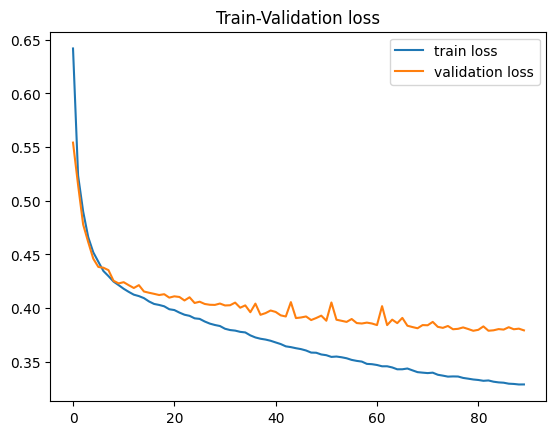

In [37]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [38]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.673469387755102, 'precision': 0.673469387755102, 'f1': 0.673469387755102, 'accuracy': 0.673469387755102}
MALE {'recall': 0.8046875, 'precision': 0.8046875, 'f1': 0.8046875, 'accuracy': 0.8046875}
FEMALE {'recall': 0.5475, 'precision': 0.5475, 'f1': 0.5475, 'accuracy': 0.5475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}
MALE {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}
FEMALE {'recall': 0.3779527559055118, 'precision': 0.3779527559055118, 'f1': 0.37795275590551175, 'accuracy': 0.3779527559055118} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6036505867014341, 'precision': 0.6036505867014341, 'f1': 0.6036505867014341, 'accuracy': 0.6036505867014341}
MALE {'recall': 0.7045454545454546, 'precision': 0.7045

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6369288186786066 	 Validation loss: 0.5481573126073611 	 
  1%|          | 574/57400 [00:03<04:46, 198.26it/s]
Epoch 2 	 Training loss: 0.538632671644048 	 Validation loss: 0.5161425395537231 	 
  2%|▏         | 1148/57400 [00:06<04:44, 197.76it/s]
Epoch 3 	 Training loss: 0.49474822711653826 	 Validation loss: 0.4889965168500351 	 
  3%|▎         | 1722/57400 [00:09<04:41, 197.86it/s]
Epoch 4 	 Training loss: 0.47183329791142137 	 Validation loss: 0.46589132436251235 	 
  4%|▍         | 2296/57400 [00:12<04:39, 197.22it/s]
Epoch 5 	 Training loss: 0.45585176270805583 	 Validation loss: 0.45072671013363336 	 
  5%|▌         | 2870/57400 [00:15<04:30, 201.53it/s]
Epoch 6 	 Training loss: 0.44539736164571514 	 Validation loss: 0.4438457140478037 	 
  6%|▌         | 3444/57400 [00:18<04:38, 193.91it/s]
Epoch 7 	 Training loss: 0.4371997726503565 	 Validation loss: 0.43741322169869634 	 
  7%|▋         | 4018/57400 [00:21<04:34, 194.65it/s]
Epoch 8 	 Training los

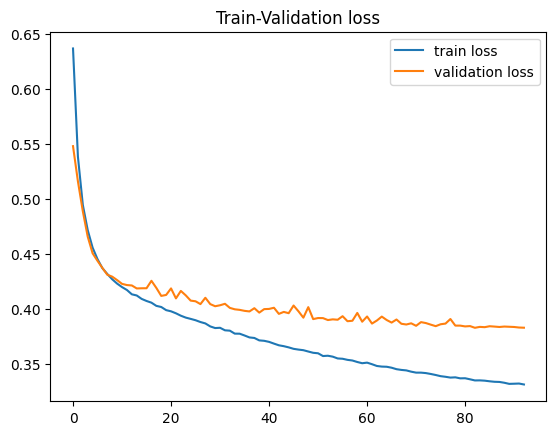

In [39]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_2'


optimizer =AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [40]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6836734693877551, 'precision': 0.6836734693877551, 'f1': 0.6836734693877551, 'accuracy': 0.6836734693877551}
MALE {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
FEMALE {'recall': 0.54, 'precision': 0.54, 'f1': 0.54, 'accuracy': 0.54} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5505050505050505, 'precision': 0.5505050505050505, 'f1': 0.5505050505050505, 'accuracy': 0.5505050505050505}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.3753280839895013, 'precision': 0.3753280839895013, 'f1': 0.3753280839895013, 'accuracy': 0.3753280839895013} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6192959582790091, 'precision': 0.6192959582790091, 'f1': 0.6192959582790091, 'accuracy': 0.6192959582790091}
MALE {'recall': 0.747474

In [30]:
del model
torch.cuda.empty_cache()

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.636573957337735 	 Validation loss: 0.5790619617801601 	 
  1%|          | 574/57400 [00:04<06:30, 145.45it/s]
Epoch 2 	 Training loss: 0.5499140163331913 	 Validation loss: 0.5186256432937364 	 
  2%|▏         | 1148/57400 [00:09<07:20, 127.60it/s]
Epoch 3 	 Training loss: 0.5073033259720753 	 Validation loss: 0.4907887881085024 	 
  3%|▎         | 1722/57400 [00:13<07:00, 132.45it/s]
Epoch 4 	 Training loss: 0.47900733756686753 	 Validation loss: 0.4670029994794878 	 
  4%|▍         | 2296/57400 [00:18<06:34, 139.65it/s]
Epoch 5 	 Training loss: 0.4617004947483747 	 Validation loss: 0.4548960348307076 	 
  5%|▌         | 2870/57400 [00:23<07:42, 117.85it/s]
Epoch 6 	 Training loss: 0.4514763345390247 	 Validation loss: 0.4451820112891116 	 
  6%|▌         | 3444/57400 [00:27<06:15, 143.80it/s]
Epoch 7 	 Training loss: 0.4427270099572604 	 Validation loss: 0.43854309239629974 	 
  7%|▋         | 4018/57400 [00:32<06:24, 139.01it/s]
Epoch 8 	 Training loss: 0.

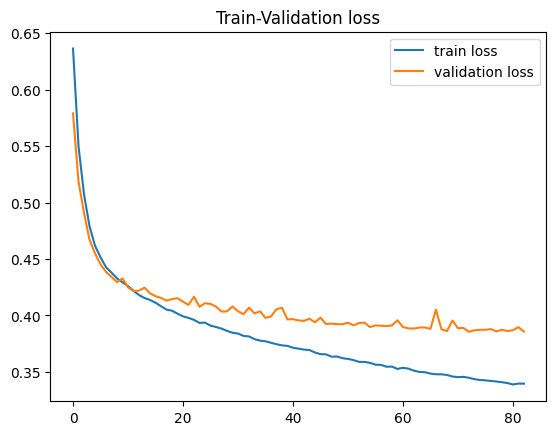

In [41]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [42]:
del model
torch.cuda.empty_cache()

In [43]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6913265306122449, 'precision': 0.6913265306122449, 'f1': 0.6913265306122449, 'accuracy': 0.6913265306122449}
MALE {'recall': 0.8255208333333334, 'precision': 0.8255208333333334, 'f1': 0.8255208333333334, 'accuracy': 0.8255208333333334}
FEMALE {'recall': 0.5625, 'precision': 0.5625, 'f1': 0.5625, 'accuracy': 0.5625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5555555555555556, 'precision': 0.5555555555555556, 'f1': 0.5555555555555556, 'accuracy': 0.5555555555555556}
MALE {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}
FEMALE {'recall': 0.3779527559055118, 'precision': 0.3779527559055118, 'f1': 0.37795275590551175, 'accuracy': 0.3779527559055118} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.60625814863103, 'precision': 0.60625814863103, 'f1': 0.60625814863103, 'accuracy': 0.60625814863103}
MALE {'recall': 0.73232

In [44]:
del model
torch.cuda.empty_cache()

In [45]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6828231292517006, 'precision': 0.6828231292517006, 'f1': 0.6828231292517006, 'accuracy': 0.6828231292517006}
Métricas etiqueta male: {'recall': 0.8211805555555556, 'precision': 0.8211805555555556, 'f1': 0.8211805555555556, 'accuracy': 0.8211805555555556}
Métricas etiqueta female:  {'recall': 0.55, 'precision': 0.55, 'f1': 0.55, 'accuracy': 0.55}

 to
Resultado global: {'recall': 0.5505050505050505, 'precision': 0.5505050505050505, 'f1': 0.5505050505050505, 'accuracy': 0.5505050505050505}
Métricas etiqueta male: {'recall': 0.7112733171127332, 'precision': 0.7112733171127332, 'f1': 0.7112733171127331, 'accuracy': 0.7112733171127332}
Métricas etiqueta female:  {'recall': 0.3770778652668416, 'precision': 0.3770778652668416, 'f1': 0.3770778652668416, 'accuracy': 0.3770778652668416}

 as
Resultado global: {'recall': 0.6097348978704911, 'precision': 0.6097348978704911, 'f1': 0.6097348978704911, 'accuracy': 0.6097348978704911}
Métrica

# TO

In [26]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934089215167308 	 Validation loss: 0.6914951690172745 	 
  1%|          | 574/57400 [00:03<04:55, 192.15it/s]
Epoch 2 	 Training loss: 0.6934412461332328 	 Validation loss: 0.6917948894581553 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<04:51, 192.75it/s]
Epoch 3 	 Training loss: 0.6934876180276638 	 Validation loss: 0.6921696268906028 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:09<04:43, 196.30it/s]
Epoch 4 	 Training loss: 0.6934419951372446 	 Validation loss: 0.6919542561143132 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<04:49, 190.24it/s]
Epoch 5 	 Training loss: 0.6933271811191213 	 Validation loss: 0.6914112881078558 	 
  5%|▌         | 2870/57400 [00:16<04:38, 195.50it/s]
Epoch 6 	 Training loss: 0.6934134438893521 	 Validation loss: 0.6915753342337527 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:19<04:35, 195.84it/s]
Epoch 7 	 Training loss: 0.6933279351074937 	 Valid

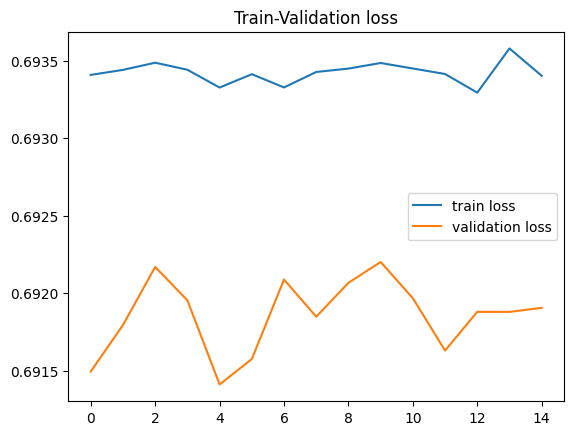

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_1'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [51]:
del model
torch.cuda.empty_cache()

In [28]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952276219474314 	 Validation loss: 0.6981707094079357 	 
  1%|          | 574/57400 [00:03<04:48, 196.98it/s]
Epoch 2 	 Training loss: 0.6949127297783563 	 Validation loss: 0.6981973456124128 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<04:54, 190.69it/s]
Epoch 3 	 Training loss: 0.6949507925360876 	 Validation loss: 0.6974321149163327 	 
  3%|▎         | 1722/57400 [00:09<04:47, 193.99it/s]
Epoch 4 	 Training loss: 0.6947599952644588 	 Validation loss: 0.6979089631872663 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:12<04:40, 196.71it/s]
Epoch 5 	 Training loss: 0.6950865076394032 	 Validation loss: 0.6980840311212054 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:15<04:39, 195.23it/s]
Epoch 6 	 Training loss: 0.6952042089522092 	 Validation loss: 0.69806259971554 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:19<04:38, 193.91it/s]
Epoch 7 	 Training loss: 0.6948760909901264 	 Validat

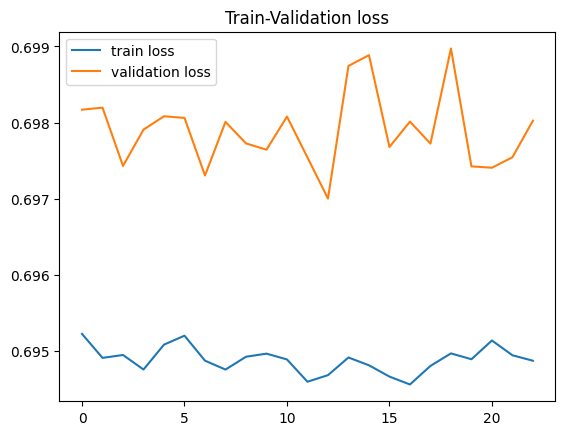

In [29]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_2'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [30]:
del model
torch.cuda.empty_cache()

In [31]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [32]:
del model
torch.cuda.empty_cache()

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940881783330898 	 Validation loss: 0.6909759468951467 	 
  1%|          | 574/57400 [00:03<05:00, 189.42it/s]
Epoch 2 	 Training loss: 0.694293370749477 	 Validation loss: 0.6920925601054047 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<04:47, 195.56it/s]
Epoch 3 	 Training loss: 0.6941002415240018 	 Validation loss: 0.691287366010375 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:09<04:50, 191.93it/s]
Epoch 4 	 Training loss: 0.6942071148327419 	 Validation loss: 0.6915585095599547 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:12<04:43, 194.09it/s]
Epoch 5 	 Training loss: 0.6939836161061862 	 Validation loss: 0.6911329334065065 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:16<04:39, 194.89it/s]
Epoch 6 	 Training loss: 0.6943252057563968 	 Validation loss: 0.6915834424859386 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:19<04:54, 183.52it/s]
Epoch 7 	 Training loss:

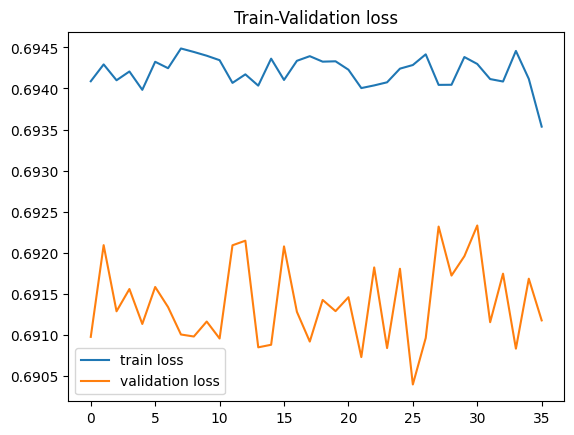

In [33]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_3'


optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [24]:
del model
torch.cuda.empty_cache()

In [35]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5034013605442177, 'precision': 0.5034013605442177, 'f1': 0.5034013605442177, 'accuracy': 0.5034013605442177}
Métricas etiqueta male: {'recall': 0.3333333333333333, 'precision': 0.3333333333333333, 'f1': 0.3333333333333333, 'accuracy': 0.3333333333333333}
Métricas etiqueta female:  {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}

 to
Resultado global: {'recall': 0.4936868686868687, 'precision': 0.4936868686868687, 'f1': 0.4936868686868687, 'accuracy': 0.4936868686868687}
Métricas etiqueta male: {'recall': 0.3333333333333333, 'precision': 0.3333333333333333, 'f1': 0.3333333333333333, 'accuracy': 0.3333333333333333}
Métricas etiqueta female:  {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}

 as
Resultado global: {'recall': 0.494567579313342, 'precision': 0.494567579313342, 'f1': 0.494

# AS

In [61]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931389493393981 	 Validation loss: 0.6937735262563673 	 
  1%|          | 574/57400 [00:03<05:10, 182.94it/s]
Epoch 2 	 Training loss: 0.6930855164752189 	 Validation loss: 0.6925595190565464 	 
  2%|▏         | 1148/57400 [00:06<05:17, 177.02it/s]
Epoch 3 	 Training loss: 0.6929397153106716 	 Validation loss: 0.6928069258140306 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:04, 182.70it/s]
Epoch 4 	 Training loss: 0.6924415846527245 	 Validation loss: 0.6918962416002306 	 
  4%|▍         | 2296/57400 [00:13<05:01, 182.85it/s]
Epoch 5 	 Training loss: 0.6905617224837844 	 Validation loss: 0.6929996831942413 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:17<04:58, 182.61it/s]
Epoch 6 	 Training loss: 0.6895566716634438 	 Validation loss: 0.6929819280818358 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:55, 182.85it/s]
Epoch 7 	 Training loss: 0.6888550775391715 	 Validation loss: 0.690256403664411

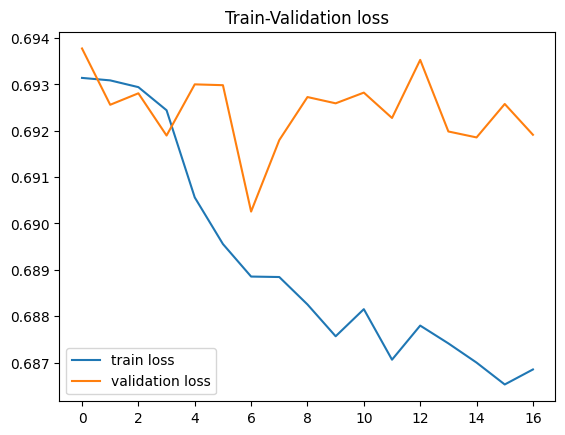

In [62]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_1'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [ ]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932233010227257 	 Validation loss: 0.6934957554784872 	 
  1%|          | 574/57400 [00:03<05:10, 182.75it/s]
Epoch 2 	 Training loss: 0.6930940067103516 	 Validation loss: 0.6923930463144334 	 
  2%|▏         | 1148/57400 [00:06<05:07, 182.81it/s]
Epoch 3 	 Training loss: 0.6928890615390153 	 Validation loss: 0.6935908956042791 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:02, 184.36it/s]
Epoch 4 	 Training loss: 0.6921624603587161 	 Validation loss: 0.6944113383858891 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:00, 183.22it/s]
Epoch 5 	 Training loss: 0.6902943666803713 	 Validation loss: 0.6923515968403574 	 
  5%|▌         | 2870/57400 [00:17<04:58, 182.50it/s]
Epoch 6 	 Training loss: 0.6894843369618525 	 Validation loss: 0.6916319495540554 	 
  6%|▌         | 3444/57400 [00:20<04:59, 180.43it/s]
Epoch 7 	 Training loss: 0.6890834858608578 	 Validation loss: 0.6919638272059165 	 

1 epoch without improve

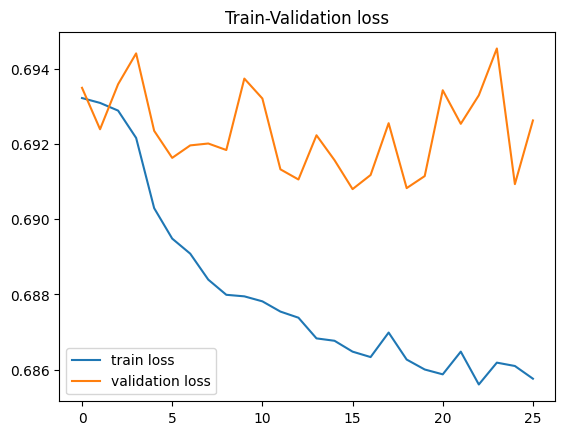

In [63]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [64]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6364795918367347, 'precision': 0.6364795918367347, 'f1': 0.6364795918367347, 'accuracy': 0.6364795918367347}
MALE {'recall': 0.5572916666666666, 'precision': 0.5572916666666666, 'f1': 0.5572916666666666, 'accuracy': 0.5572916666666666}
FEMALE {'recall': 0.7125, 'precision': 0.7125, 'f1': 0.7125, 'accuracy': 0.7125} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5138888888888888, 'precision': 0.5138888888888888, 'f1': 0.5138888888888888, 'accuracy': 0.5138888888888888}
MALE {'recall': 0.45498783454987834, 'precision': 0.45498783454987834, 'f1': 0.45498783454987834, 'accuracy': 0.45498783454987834}
FEMALE {'recall': 0.5774278215223098, 'precision': 0.5774278215223098, 'f1': 0.5774278215223098, 'accuracy': 0.5774278215223098} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6101694915254238, 'precision': 0.6101694915254238, 'f1': 0.6101694915254238, 'accuracy': 0.6101694915254238}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932250400453495 	 Validation loss: 0.6923049476187108 	 
  1%|          | 574/57400 [00:03<05:08, 184.38it/s]
Epoch 2 	 Training loss: 0.6931024819924025 	 Validation loss: 0.6925679303831973 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:11, 180.67it/s]
Epoch 3 	 Training loss: 0.6930895174629597 	 Validation loss: 0.6926562159748401 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:04, 182.84it/s]
Epoch 4 	 Training loss: 0.6926937249687075 	 Validation loss: 0.6922548332456815 	 
  4%|▍         | 2296/57400 [00:13<05:00, 183.26it/s]
Epoch 5 	 Training loss: 0.6911528298456079 	 Validation loss: 0.6925964840387894 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:17<04:58, 182.51it/s]
Epoch 6 	 Training loss: 0.690310409571651 	 Validation loss: 0.6945056198006969 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:55, 182.62it/s]
Epoch 7 	 Training loss: 0.6889208613372431 	 Valida

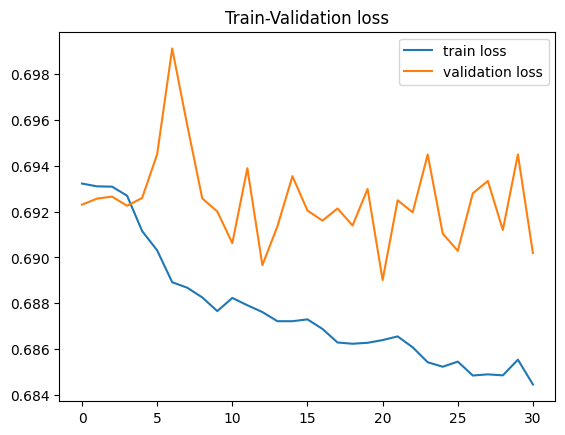

In [65]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [66]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6505102040816326, 'precision': 0.6505102040816326, 'f1': 0.6505102040816326, 'accuracy': 0.6505102040816326}
MALE {'recall': 0.5182291666666666, 'precision': 0.5182291666666666, 'f1': 0.5182291666666666, 'accuracy': 0.5182291666666666}
FEMALE {'recall': 0.7775, 'precision': 0.7775, 'f1': 0.7775, 'accuracy': 0.7775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5252525252525253, 'precision': 0.5252525252525253, 'f1': 0.5252525252525253, 'accuracy': 0.5252525252525253}
MALE {'recall': 0.38929440389294406, 'precision': 0.38929440389294406, 'f1': 0.38929440389294406, 'accuracy': 0.38929440389294406}
FEMALE {'recall': 0.6719160104986877, 'precision': 0.6719160104986877, 'f1': 0.6719160104986877, 'accuracy': 0.6719160104986877} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6036505867014341, 'precision': 0.6036505867014341, 'f1': 0.6036505867014341, 'accuracy': 0.6036505867014341}
MALE {'recal

In [67]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6434948979591837, 'precision': 0.6434948979591837, 'f1': 0.6434948979591837, 'accuracy': 0.6434948979591837}
Métricas etiqueta male: {'recall': 0.5377604166666666, 'precision': 0.5377604166666666, 'f1': 0.5377604166666666, 'accuracy': 0.5377604166666666}
Métricas etiqueta female:  {'recall': 0.745, 'precision': 0.745, 'f1': 0.745, 'accuracy': 0.745}

 to
Resultado global: {'recall': 0.5195707070707071, 'precision': 0.5195707070707071, 'f1': 0.5195707070707071, 'accuracy': 0.5195707070707071}
Métricas etiqueta male: {'recall': 0.4221411192214112, 'precision': 0.4221411192214112, 'f1': 0.4221411192214112, 'accuracy': 0.4221411192214112}
Métricas etiqueta female:  {'recall': 0.6246719160104988, 'precision': 0.6246719160104988, 'f1': 0.6246719160104988, 'accuracy': 0.6246719160104988}

 as
Resultado global: {'recall': 0.606910039113429, 'precision': 0.606910039113429, 'f1': 0.606910039113429, 'accuracy': 0.606910039113429}
Métrica